<!--COURSE_INFORMATION-->
*This notebook contains course material from [CBE 30338 Chemical Process Control](http://jckantor.github.io/CBE30338/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/CBE30338).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Visual Tracking of an Object with a Drone](C.02-Visual-Tracking-of-an-Object-with-a-Drone.ipynb) | [Contents](index.ipynb) |

<a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/C.03-Optimal-Control-for-Cooking-Meats.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Optimal Control for Cooking Meats

CBE 30338, Spring 2019

 Matthew Magiera, Loyal Murphy, David Pedler, and Kyle Tomshack

## Problem Statement

From trichinella roundworms in pork, to salmonella bacteria found in chicken, microorganisms present in undercooked meat are greatly hazardous to the people who consume them, and can leave companies potentially liable for consumers’ medical expenses. However, individuals do not want to consume overcooked meat, as it lacks the flavor and texture which people desire from their food. Carnivores want the product they order or cook themselves to be cooked properly, achieving a desired level of doneness. Commercially, optimization of cooking time and temperature presents opportunities for savings in time and energy as well as a reduction in waste (from overcooking) and potential contamination (from undercooking). Increased efficiency and control in cooking meat is highly desirable as both meat and fuel prices climb.  Recommended cook times are often given in wide temperature ranges, and because of the differences in size and shape of the meat and personal preference, it may be difficult to find a recommended cook time that suits the particulars of a situation. 

While meat can be monitored throughout the cooking process, the internal temperature profile cannot be directly measured without disturbing the meat itself. Currently, one of the only ways to check for doneness is using a metal temperature probe inserted into the thickest part of the meat. Purchasing a temperature probe is expensive for the at-home cook, and the act of inserting the probe into the thickest part of the meat can be time-consuming if attempting to cook many pieces of meat. Additionally, the temperature probe will need to be washed regularly while cooking if reusable; if not, the probe will need to be thrown away. In both cases, the use of temperature probes increases the hassle and cost of cooking. This motivates a model of the temperature profile which can then be used to identify the ideal cooking time and temperature. 

The goal of this model is to develop and optimize a model for cooking meat, specifically a steak, that will provide directions for cooking the steak to the desired doneness. It also takes into account the consistency of the final product, searching for the ideal conditions under which the interior of the steak will have a consistent temperature near the desired doneness.

Three basic recipe criteria are required to cook a steak: the temperature of the grill, the total cook time, and the time at which the steak should be flipped. After inputting a desired level of doneness (rare to well done), the model will be able to identify a total cook time and recommended flip time for the steak based on grill temperature.


## Theory

### Model Development

One key assumption in the model is that the heat transfer occurs only along one dimension, the depth of the steak. The model therefore assumes a "flat-iron" style grill, which provides uniform heat across its surface, rather than the more common "open-flame" grill. It is assumed that the air around the steak is at ambient temperature, and thus does not heat the steak from the sides. This greatly simplifies the model by eliminating the problem of heat transfer into or out of the sides of the steak, and allows us to utilize the following equation for unidimensional heat transfer: $$\frac{\partial T}{\partial t}=\alpha \frac{\partial ^2 T}{\partial z^2}$$. 

However, additional complexities occur after the steak is flipped, when there is heat transfer into the steak from the grill below and an additional effect caused by the top face of the steak. This surface has gone from being in direct contact with the hot grill, to exposure in ambient air, resulting in both cooling on contact with air and heat transfer down into the steak. The diagram below illustrates the heat transfer in each part of the cooking process. In the first image, heat is enters the steak from the grill. In the second image, heat enters the steak from the grill and from the top face, and leaves from the steak into the air. 


![alt text](https://nd.digication.com/files/M03ddb30894afe8b8e0fb5ef05d8982e0.jpg) ![alt text](https://nd.digication.com/files/M932d3bff3717135c792c0d6e452a5718.jpg)

### Thermal Properties of Meat

This model also assumes that the governing thermal properties of meat, namely the thermal diffusivity, do not change throughout the cooking process. Thermal diffusivity is a ratio of thermal conductivity to the product of density and specific heat capacity: $\alpha=\frac{k_T}{\rho \cdot \hat{C}_p}$. While these properties are commonly assumed to be constant over small temperature ranges, the temperature range in this model spans over a hundred degrees Celsius, from the surface of the cooktop to the ambient air temperature. Using various available literature sources detailing the thermal properties of similar cuts of meat (largely whole beef chuck), an estimation was extrapolated for specific heat, density, and thermal conductivity, using temperature and moisture content data. 

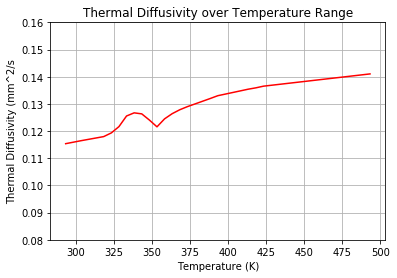

In [0]:
import numpy as np
import matplotlib.pyplot as plt
alpha=[0.115363862,0.115907311,0.116450748,0.116957906,0.117464687,0.117971092,0.119328638,0.12163458,0.125549741,0.126707608,0.126330865,0.124063738,0.121565241,0.12450427,0.126407234,0.127852546,0.128996253,0.129988159,0.13098517,0.131987318,0.133023339,0.133618419,0.134215976,0.134816024,0.13541858,0.135911027,0.136524328,0.136846319,0.13716831,0.137490302,0.137812293,0.138134284,0.138456276,0.138778267,0.139100258,0.13942225,0.139744241,0.140066233,0.140388224,0.140710215,0.141032207]
TarrayK=[293.15, 298.15,303.15,308.15,313.15,318.15,323.15,328.15,333.15,338.15,343.15,348.15,353.15,358.15,363.15,368.15,373.15,378.15,383.15,388.15,393.15,398.15,403.15,408.15,413.15,418.15,423.15,428.15,433.15,438.15,443.15,448.15,453.15,458.15,463.15,468.15,473.15,478.15,483.15,488.15,493.15]
plt.plot(TarrayK,alpha,'r-')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Diffusivity (mm^2/s')
plt.title('Thermal Diffusivity over Temperature Range')
plt.ylim([.08,.16])
plt.grid()


The estimation plotted above shows that while the estimated value of $\alpha=0.12 \frac{mm^2}{s}$ is a good approximation for the lower range $300 K < T < 350 K$ relevant for the center of the meat, an upward trend in $\alpha$ could cause inaccuracies towards the higher temperature edge regions. This is not ideal, but the temperature profile towards the center of the meat is much more important for the safety and quality of the cooked product. Another interesting insight this graph provides is an indication of a disturbance around 340 K; it is around this temperature that proteins in the meat begin to denature, and significant water loss dramatically alters the density and the specific heat of the meat. The appendix contains  an analogous graph estimating percent water loss in ground chuck modeled for a continuous heating process. <br>

In addition to these properties, the Maillard reaction is an important element in this process. When certain sugars in the steak are heated to temperatures over 140$^o$C, they deform to create new sugars that give the steak its signature brown coloring, as well as give the steak a more rich and savory flavor. While this simulation does not look into the thermodynamics of the Maillard reaction, this reaction was used to determine the minimum threshold for the grill temperature. 



###Python Implementation 

The model is implemented using a Pyomo Concrete Model, in which the differential equations governing the heat transfer are solved using the SolverFactory central finite difference method with Ipopt. The temperature and time are both made dimensionless in the model to simplify the equations. 
The model minimizes the objective function 
$$ \int _0 ^{L} \big ( T_{actual} - T_{desired} \big ) ^2 \cdot \big (  \frac{1}{\sqrt{2 \pi \sigma}} \cdot e^{\frac{-(x-.5)^2}{2 \sigma ^2}} \big ) dx $$
where the first term represents the temperature gradient and the second term acts as a weighting factor. This weighting factor has a Gaussian shape, which reduces the relative importance of the doneness of the edges of the meat while prioritizing center temperature. As stated earlier, this is not only because the modeling assumptions are most accurate in a lower temperature range, but also because the center of a steak serves as the primary indicator of doneness and uniformity in the finished product. 

Because the orientation of the steak is changed during the cooking process, the boundary conditions are more complex than basic unidirectional heat transfer. In the model, the boundary conditions for the heat transfer equation are manipulated to account for the flip using if statements to decide on boundary condititons based on time relative to flip time and constraint skips to avoid error. 


## Executable Element

### Import Libraries and Solver

In [0]:
!pip install -q pyomo==5.6.1
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
ipopt_executable = '/content/ipopt'

     |████████████████████████████████| 2.1MB 2.8MB/s 
     |████████████████████████████████| 256kB 47.7MB/s 
     |████████████████████████████████| 51kB 19.8MB/s 


In [0]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *
import numpy as np
from scipy import special
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import Axes3D

### Initialize Basic Parameters

In [0]:
# Maillard and Pyrolysis (may use for added constraints)
T_maillard =  413.7 # K, 285 deg F ... T that the Maillard must take place
T_pyrolysis = 452.6 # K  355 deg F ... T that pyrolysis (burning) starts

# Desired values for the inside temperature of the steak
T_rare = 324.8 # K, 125 deg F
T_m_rare= 330.4 # K, 135 deg F
T_medium = 335.9 # K, 145 deg F
T_m_well = 341.5 # K, 155 deg F
T_well_done = 347.0 # K, 165 deg F
T_grill = 450 # grill temperature (K)
T_amb = 291.5 #K, Assume that the meat is at the same temperature as the room at the start of the experiment

L = 3  # cm, Thickness of the steak
alpha = 1.2e-3 # cm^2/s, thermal diffusivity of the meat

### Plot Function
The following function will be used to organize the pyomo model variables and plot the final temperature of the meat with respect to position.

In [0]:
def model_plot(m, t_flip, T_desired):
  # This function organizes the results from the pyomo model.
  # Then it plots the depth into the steak on the x-axis
  # and the final temperature on the y-axis.
    x = sorted(m.x)
    t = sorted(m.t)

    xgrid = np.zeros((len(t), len(x)))
    tgrid = np.zeros((len(t), len(x)))
    Tgrid = np.zeros((len(t), len(x)))

    for i in range(0, len(t)):
        for j in range(0, len(x)):
            xgrid[i,j] = x[j] * L # converts dimless to cm
            tgrid[i,j] = t[i] * m.t_final.value # converts dimless to sec
            Tgrid[i,j] = m.T[t[i], x[j]].value * (T_grill - T_amb)+T_amb # converts dimless to K
            
    # create plot and set elements        
    flip_str = 'Flip Time = ' + str(t_flip * m.t_final.value) + ' sec.'
    Temp_str = 'Desired Center Temperature = ' + str(T_desired) + ' K'
    final_str = 'Total Time = ' + str(round(m.t_final.value, 3)) + ' sec.'
    grill_str = 'Grill Temperature = ' + str(T_grill) +' K'
    if T_desired == 324.8:
      done='Rare'
    if T_desired == 330.4:
      done='Medium Rare'
    if T_desired == 335.9:
      done='Medium'
    if T_desired == 341.5:
      done='Medium Well'
    if T_desired == 347.0:
      done='Well Done'
    done_str = 'Level of Doneness: '+done
    new_str = str(round(t_flip,3)) + ', ' + final_str
    plt.plot(xgrid[len(t)-1,:],Tgrid[len(t)-1,:],label=new_str)
    plt.xlabel('Depth (cm)')
    plt.ylabel('Final Temperature (K)')
    plt.title('Final Temperature with Respect to Depth')
    plt.text(1.9, 310, grill_str, fontsize=10)
    plt.text(1.9, 300, done_str, fontsize=10)
    plt.text(1.9, 290, Temp_str, fontsize=10)

### Simulation Function

The following code creates a model of the meat being heated by a grill. The model is solved using ipopt. 

In [0]:
def grill(t_flip, T_desired):
  # Initialize model
  m = ConcreteModel()

  # Set Variables
  m.t = ContinuousSet(bounds=(0, 1)) # time dimless
  m.x = ContinuousSet(bounds=(0, 1)) # depth into the meat dimless
  m.t_final = Var(domain=NonNegativeReals, initialize = 700) # potential future variable
  m.T = Var(m.t, m.x) # temperature dimless
  m.dTdt = DerivativeVar(m.T, wrt=m.t) # 1st derivative of temp wrt time
  m.dTdx = DerivativeVar(m.T, wrt=m.x) # 1st derivative of Temp wrt position
  m.d2Tdx2 = DerivativeVar(m.T, wrt=(m.x, m.x)) # 2nd derivative of Temp wrt position


  # Constraint: Governing Diff Equation
  @m.Constraint(m.t, m.x)
  def pde(m, t, x):
      if t == 0:
          return Constraint.Skip
      if x == 0 or x == 1:
          return Constraint.Skip
      return m.dTdt[t,x] == m.t_final * alpha * m.d2Tdx2[t,x] / L**2



  # Constraint: Initial Conditions
  m.ic  = Constraint(m.x, rule=lambda m, x:    m.T[0,x] == 0 if x > 0 and x < 1 else Constraint.Skip)

  # Constraint: Boundary Conditions
  # Conditions are dependent on flip time
  # Conditions are constant throughout the test
  m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,0] == 1 if t < t_flip else m.T[t,1] == 1)

  m.bc2 = Constraint(m.t, rule=lambda m, t:   m.T[t,1] == 0 if t < t_flip else m.T[t,0] == 0)

  # Objective function
  sigma2=.001
  m.int = Integral(m.x, wrt=m.x, rule=lambda m, x: (((m.T[1,x]*(T_grill-T_amb)+T_amb)-T_desired)**2 * (1/np.sqrt(2*np.pi*sigma2)*np.exp(-(x-.5)**2/2/sigma2))))
  m.obj = Objective(expr = m.int, sense=minimize)

  # Solver uses ipopt to solve model
  # Solves wrt position and time
  TransformationFactory('dae.finite_difference').apply_to(m, scheme='Central', wrt=m.x, nfe=50)
  TransformationFactory('dae.finite_difference').apply_to(m, scheme='Central', wrt=m.t, nfe=50)
  SolverFactory('ipopt', executable=ipopt_executable).solve(m, tee=False)

  # plot final temperature vs position
  model_plot(m, t_flip, T_desired) 

## Results

Each of the following cells run the simulation function with a different desired levels of doneness and different grill temperatures. In each plot, the legend states the fraction of total cook time when the flip occurred and the total cook time. For example, "0.5, Total Time = 800 sec." means that the total time it took to cook the meat was 800 seconds and the meat was flipped at 400 seconds. On each of the following plots, the temperature profile at the end of the grilling is displayed over the depth of the steak. To clarify, the depth at zero value is the surface of the steak that initially touches the grill. In a similar way, the depth of three centimeters refers to the surface of the steak that is not initially touching the grill. This is why in every plot the depth at zero is at ambient temperature, and the depth at three centimeters is at the grill temperature.

### Level of Doneness: Rare, Grill Temperature: 450 K

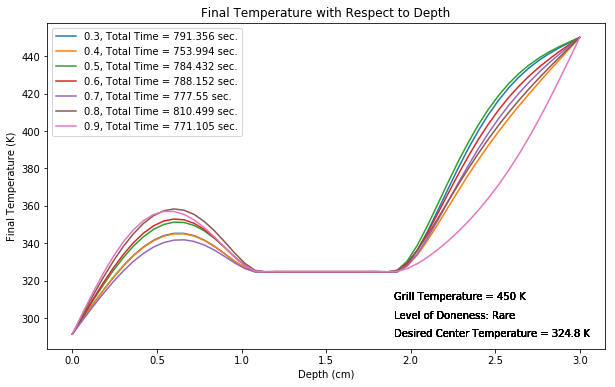

In [0]:
plt.figure(figsize=(10,6))
# For loop solves for multiple flip times  
for t_flip in np.linspace(0.3, 0.9, 7):
  grill(t_flip, T_rare)
plt.legend()
plt.show()

The desired center temperature, 324.8 K, was reached in all seven simulations, however the total cook time varied, ranging from 753.994 seconds to 810.449 seconds. The optimal flip occurs 40% into cooking. This results in the most even final temperature profile while at the same time having the shortest cook time.

### Level of Doneness: Medium Rare, Grill Temperature: 450 K

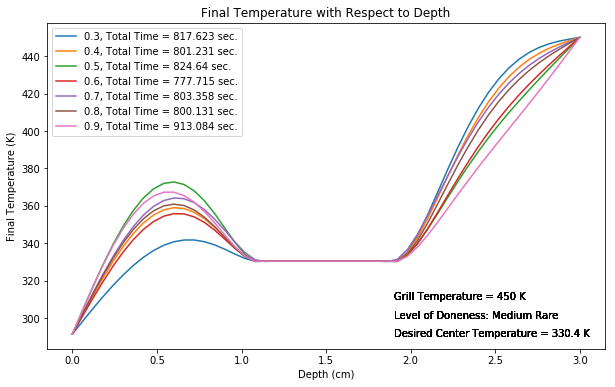

In [0]:
plt.figure(figsize=(10,6))
# For loop solves for multiple flip times  
for t_flip in np.linspace(0.3, 0.9, 7):
  grill(t_flip, T_m_rare)
plt.legend()
plt.show()

The desired center temperature, 330.4 K, was reached in all seven simulations, however the total cook time varied, ranging from 777.715 seconds to 913.084 seconds. The optimal flip occurs 60% into cooking. This results in the most even final temperature profile while at the same time having the shortest cook time.

### Level of Doneness: Medium, Grill Temperature: 450 K

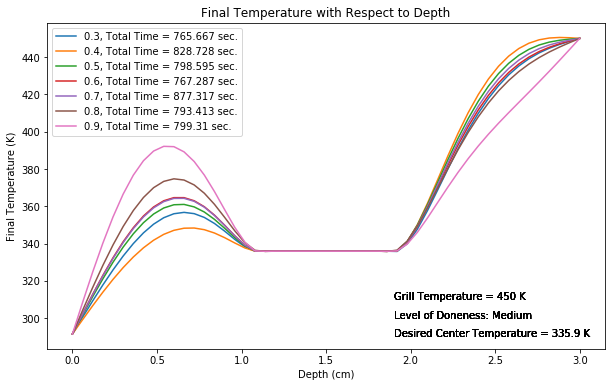

In [0]:
plt.figure(figsize=(10,6))
# For loop solves for multiple flip times  
for t_flip in np.linspace(0.3, 0.9, 7):
  grill(t_flip, T_medium)
plt.legend()
plt.show()

The desired center temperature, 335.9 K, was reached in all seven simulations, however the total cook time varied, ranging from 765.667 seconds to 877.317 seconds. The optimal flip occurs 30% into cooking. This results in the most even final temperature profile while at the same time having the shortest cook time.

### Level of Doneness: Medium Well, Grill Temperature: 450 K

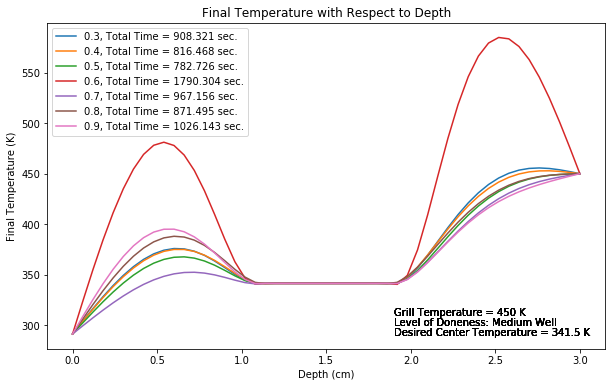

In [0]:
plt.figure(figsize=(10,6))
# For loop solves for multiple flip times  
for t_flip in np.linspace(0.3, 0.9, 7):
  grill(t_flip, T_m_well)
plt.legend()
plt.show()

The desired center temperature, 341.5 K, was reached in all seven simulations, however not all of the simulations are realistic. The 0.6 flip simulation yields a final temperature profile which is impossible because the final temperature in much of the meat is greater than the grill temperature. This was assumed to be an error in the solver caused by not having enough data points. More data points was found to be too computationally expensive. The total cook time varied, ranging from 782.726 seconds to 1026.143 seconds, ignoring unrealistic results. The optimal flip occurs 50% into cooking. This results in the most even final temperature profile while at the same time having the shortest cook time.

### Level of Doneness: Well Done, Grill Temperature: 450 K

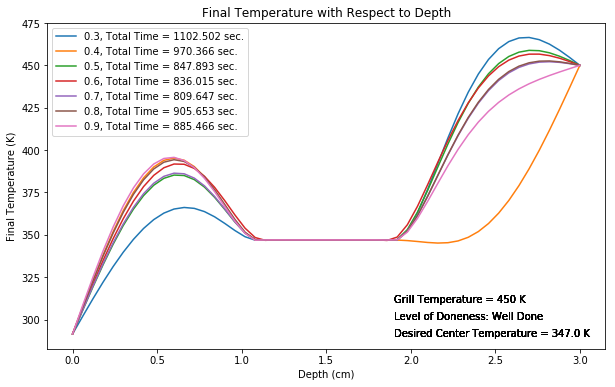

In [0]:
plt.figure(figsize=(10,6))
# For loop solves for multiple flip times  
for t_flip in np.linspace(0.3, 0.9, 7):
  grill(t_flip, T_well_done)
plt.legend()
plt.show()

The desired center temperature, 347.0 K, was reached in all seven simulations.  However, three of the simulations were unrealistic, specifically the 0.3, 0.5, and 0.6 flip times. This was assumed to be an error in the solver caused by not having enough data points. More data points was found to be too computationally expensive. The total cook time varied, ranging from 809.647 seconds to 970.366 seconds. The optimal flip occurs 70% into cooking. This results in the most even final temperature profile while at the same time having the shortest cook time.

### Level of Doneness: Rare, Grill Temperature: 400 K

In [0]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Saving Grill_400.PNG to Grill_400.PNG
Saving Grill_500.PNG to Grill_500.PNG
Saving Grill_550.PNG to Grill_550.PNG
Saving Grill_600.PNG to Grill_600.PNG


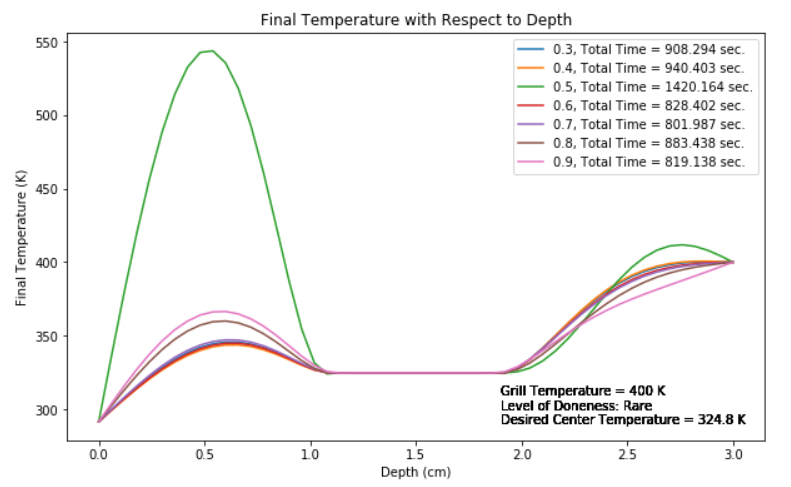

In [0]:
Image('Grill_400.PNG')

In every simulation, the desired temperature of the interior was reached. At a grill temperature of 400K, the fastest cook time was around 800 seconds near the 0.7 flip time. What was interesting to note is that the simulation at 0.5 is clearly impossible, since the temperature of the steak exceeds that of the grill in many places. Presumably, because the Pyomo solver is solving for tens of thousands of variables each trial, the solver was not able to find a more precise solution in a reasonable amount of time. 

### Level of Doneness: Rare, Grill Temperature: 500 K

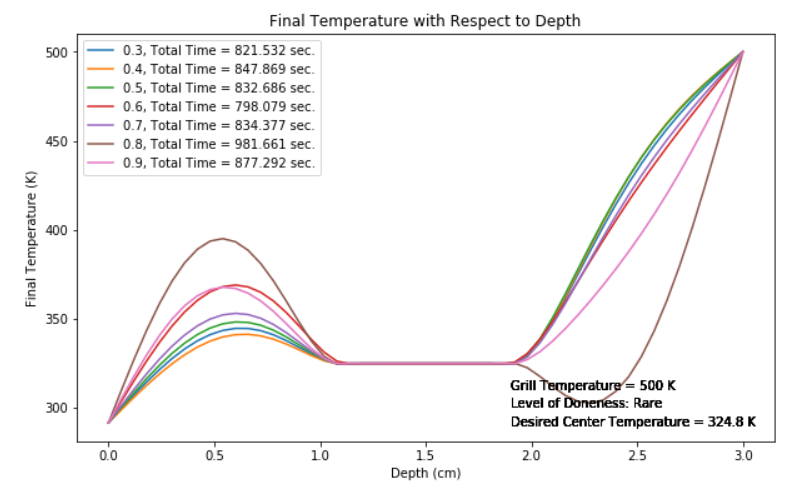

In [0]:
Image('Grill_500.PNG')

In every simulation, the desired temperature of the interior was reached. At a grill temperature of 500K, the fastest cook time was slightly below 800 seconds, near the 0.6 flip time. What is curious about this simulation is the large dip in temperature around 2.3cm into the steak. This could be attributed to several factors. One reason may be because the steak cooked at a 0.8 flip time is primarily cooked on one side, so the other side will obviously not be as warm. However, it seems that the 0.9 did not follow this trend. Most likely, this is another issue with the solver.

### Level of Doneness: Rare, Grill Temperature: 550 K

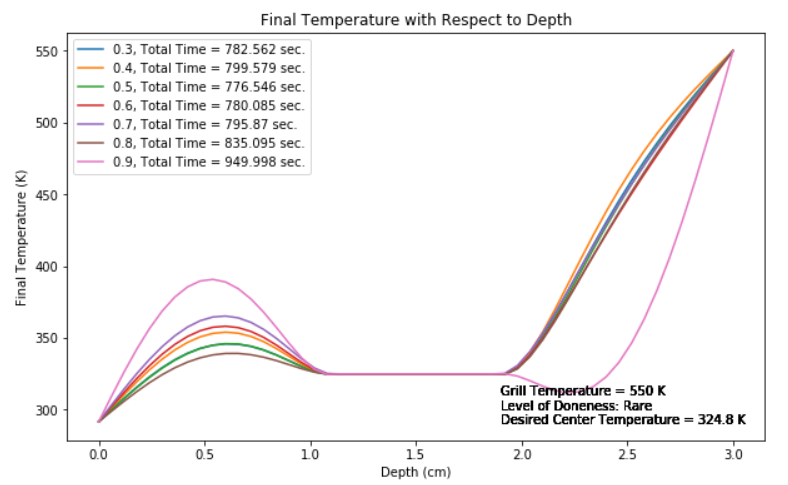

In [0]:
Image('Grill_550.PNG')

In every simulation, the desired temperature of the interior was reached. At a grill temperature of 550K, the fastest cook time was around 775 seconds somewhere in between 0.5 and 0.6 for the flip time. Like the model of the grill at 500K, one trial (0.9 flip time) experienced this drop in temperature. See the above comments for explanations.

### Level of Doneness: Rare, Grill Temperature: 600 K

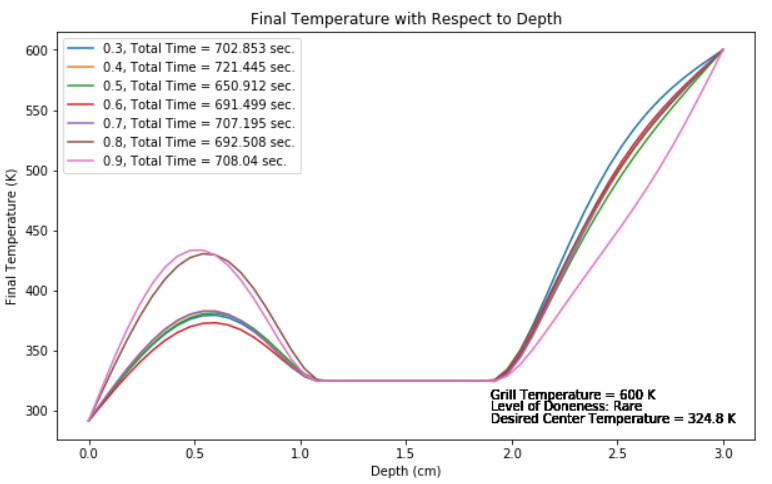

In [0]:
Image('Grill_600.PNG')

In every simulation, the desired temperature of the interior was reached. At a grill temperature of 600K, the optimal cook time was roughly 650 seconds, at a flip time around 0.5.

## Conclusions

The table below summarizes the results of the simulations.

| Level of Doneness | Grill Temperature (K) | Optimal Flip (Fraction of Total Time) | Total Cook Time (sec.) |
|---|---|---|---|
| Well Done | 450 | 0.7 | 809.647 |
| Medium Well | 450 | 0.5 | 782.726 |
|Medium | 450 | 0.3 | 765.667 |
|Medium Rare | 450 | 0.6 | 777.715 |
| Rare | 450 | 0.4 | 753.994 |
| Rare | 400 | 0.7 | 801.987 |
| Rare | 500 | 0.6 | 798.079|
| Rare | 550 | 0.5 | 776.546 |
| Rare | 600 | 0.5 | 650.912 |

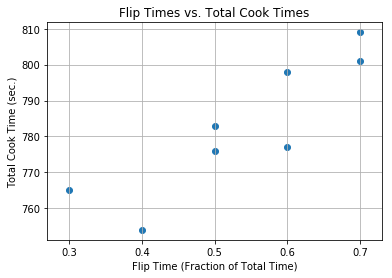

In [0]:
x = [.3, .4, .5, .5, .6, .6, .7, .7]
y = [765, 754, 783, 776, 777, 798, 809, 801]
plt.scatter(x, y)
plt.xlabel('Flip Time (Fraction of Total Time)')
plt.ylabel('Total Cook Time (sec.)')
plt.title('Flip Times vs. Total Cook Times')
plt.grid(True)
plt.show()

There are some apparent trends between the data, particularly when analyzing the change in grill temperatures. The most obvious is that total cook time decreased as the grill temperature increased. This result is fairly intuitive. Something not as intuitive is that the flip time decreases as the grill temperature increases. Although not as apparent as with changing the level of doneness, the trend seems to be that the longer the steak is on the grill, the later the flip time should be. This data is consistant with recommendations from world-famous chef, Bobby Flay, that well done steaks should be cooked longer on one side than another, while rare steaks should be cooked around equal time on both sides. While it is doubtful that Flay calculated these values using qualitative analysis of simulated results, his many years of experience in the kitchen and worldwide popularity give him great credibility.

## Future Directions and Recommendations

As mentioned in the Theory section, the thermal diffusivity of the meat changes as the temperature of the meat increases, and this is not modeled in the plots. Currently, the thermal diffusivity of the meat was set at 1.2e-3 cm$^2$/s, which would be the approximate value of the thermal diffusivity at ambient temperature. The actual thermal diffusivity ranges from 1.2e-3 cm$^2$/s to 1.5e-3 cm$^2$/s over the cooking temperatures modelled above. In addition to thermal diffusivity, the moisture content of the steak should be modeled as well. How these properties would affect the results is not clear, and further study could show what effect, if any, this has. In addition, analyzing the dependence of total grill time on steak thickness would also be informative. Presumably, the grill time would increase with increasing steak depth, as there would be more steak to cook.


## Appendix

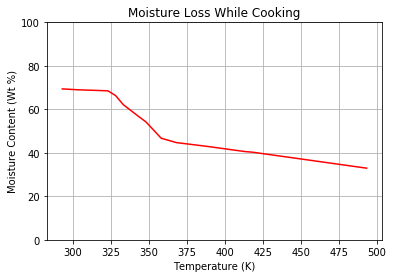

In [0]:
MC=[69.4,69.2,69,68.88,68.76,68.64,68.5,66.35,62.2,59.5,56.8,54.2,50.45,46.7,45.7,44.7,44.27,43.84,43.41,42.98,42.5,42.02,41.54,41.06,40.58,40.29,39.8,39.31,38.82,38.33,37.84,37.35,36.86,36.37,35.88,35.39,34.9,34.41,33.92,33.43,32.94]
plt.plot(TarrayK,MC,'r-')
plt.xlabel('Temperature (K)')
plt.ylabel('Moisture Content (Wt %)')
plt.title('Moisture Loss While Cooking')
plt.ylim([0,100])
plt.grid()

## References

Ashrae Handbook. Atlanta, Ga: American Society of Heating, Refrigerating and Air Conditioning Engineers, (9)  2006. Print. <br>

Jai-Yul Kong, Toshimasa Yano, Jong-Deog Kim, Seoung-Kwon Bae, MinYoung Kim & In-Soo Kong (1994) Prediction of Effective Thermal Diffusivity of Fish and Meats, Bioscience, Biotechnology, and Biochemistry, 58:11, 1942-1946, DOI: 10.1271/bbb.58.1942<br>

Perez, M. G. and Calvelo, A. (1984), Modeling the Thermal Conductivity of Cooked Meat. Journal of Food Science, 49: 152-156. doi:10.1111/j.1365-2621.1984.tb13694.x<br>

Baghe‐Khandan, M. S. and Okos, M. R. (1981), Effect of Cooking on the Thermal Conductivity of Whole and Ground Lean Beef. Journal of Food Science, 46: 1302-1305. doi:10.1111/j.1365-2621.1981.tb04159.x<br>

Elansari, Atef & Hobani, Ali. (2009). Effect of Temperature and Moisture Content on Thermal Conductivity of Four Types of Meat. International Journal of Food Properties - INT J FOOD PROP. 12. 308-315. 10.1080/10942910701687519. <br>

Flay, Bobby. “Perfectly Grilled Steak.” Food Network, Food Network, 4 June 2014, www.foodnetwork.com/recipes/bobby-flay/perfectly-grilled-steak-recipe-1973350.<br>

Leitman, Jerry D. “Thermal Conductivity of Meats.” Georgia Institute of Technology, 1967. Web. https://smartech.gatech.edu/bitstream/handle/1853/15992/leitman_jerry_d_196705_ ms_111460.pdf<br>

“The Science of Grilling Meat.” Decagon Devices. Web. http://manuals.decagon.com/Applicati on%20Notes/13901_Science%20of%20Grilling%20Meat_Print.pdf

## Statement of Contributions

This project was conducted by Matthew Magiera, Loyal Murphy, David Pedler, and Kyle Tomshack, with assistance from Dr. Jeffrey Kantor. For this project, we separated the responsibilities in order to maximize this group’s productivity. That being said, every member worked on the general theory as well as the pseudo-code for this project. Murphy and Tomshack worked primarily on the code, while Magiera and Pedler composed most of the reports. The group felt that this was an even way to divide up the responsibilities throughout the entirety of the project. All members were consulted with this 'Statement of Contributions' and agreed that this was a fair and accurate assessment of the responsibilities and workload.

<!--NAVIGATION-->
< [Visual Tracking of an Object with a Drone](C.02-Visual-Tracking-of-an-Object-with-a-Drone.ipynb) | [Contents](index.ipynb) |

<a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/C.03-Optimal-Control-for-Cooking-Meats.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
